In [1]:
import numpy as np
import pandas as pd
import warnings # 경고 메시지 무시
warnings.filterwarnings(action='ignore')
# 한국어 형태소 분석기 중 성능이 가장 우수한 Mecab 사용
from konlpy.tag import Mecab
mecab = Mecab()
from tqdm import tqdm # 작업 프로세스 시각화
import re # 문자열 처리를 위한 정규표현식 패키지
from gensim import corpora # 단어 빈도수 계산 패키지
import gensim # LDA 모델 활용 목적
import pyLDAvis # LDA 시각화용 패키지
from collections import Counter # 단어 등장 횟수 카운트
from gensim.models.coherencemodel import CoherenceModel

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

%cd /home/user_3/medistream-recsys/Script
from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/user_3/medistream-recsys/Script


In [3]:
df1 = pd.read_json('/home/user_1/medistream-recsys/Script/YS/df_book_clean.json')
df = df1.copy()
df.shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(372, 15)

In [4]:
df2 = pd.read_json('/home/user_4/CBF/article_sum.json')
df2 = df2.copy()
df2.shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3438, 5)

In [54]:
df_des = pd.concat([df['description'],df2['content_tag_removed']])

In [80]:
df_des

,문서 번호,index,title,description
0,0,0,KCD 한방내과 진찰진단 가이드라인,의 번째 큐레이션 상시판매 권승원의 한방내과 진찰진단 가이드라인 의학은빠른속...
1,1,1,우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를 목표로 ...
2,2,2,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,_ 출판사 리뷰년전 소수 인원이 모여 시작한 통증 공부 모임이 작은 불씨가 ...
3,3,3,의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야 하는 응급의학 실전지침서
4,4,4,복부 초음파 정석,_ 저자서문 초음파 검사는 임상 영역에서 청진기로 불릴 정도로 간편한...
...,...,...,...,...
3805,3805,3433,"[나의 인턴 일지] Ep.04 한의대생, 퇴사를 했다.",선생님들 안녕하세요! 꽤 오랜만에 글을 씁니다. 저 퇴사를 했습...
3806,3806,3434,초음파 케이스: shoulder impingement synd. (SASD burs...,# CASE 13 houlder iigeet yd. SASD uriti 37...
3807,3807,3435,비판적으로 논문 읽기: 통계적 보정에 대해,"얼마 전 COVID-19를 앓고 난 뒤 남아 있는 여러 증상들, 롱 코비드Log ..."
3808,3808,3436,[작가가 입사했다] Ep.09 작가가.. 혹사했다..,"여름 휴가 기간은 쏜살같이 지났고, 여전히 메디스트림은 바쁘다. 엎친데 덮..."


In [57]:
df

,_id,category_id_x,date_created,name_x,description,meta_description_x,meta_title,tags_x,three_months,regular_price_y,m_name,L_name,s_name,book_corpus,book_corpus_konlp
0,5d13115e32026c0b35383897,5cf8bbba0098b2225c5dfaa3,{'$date': '2019-06-26T06:31:58.090Z'},KCD 한방내과 진찰진단 가이드라인,의 번째 큐레이션 상시판매 권승원의 한방내과 진찰진단 가이드라인 의학은빠른속...,진료에 어려움 있을 때 먼저 찾는 책,KCD 한방내과 진찰진단 가이드라인,[가온해미디어],35,150000.0,전문,도서,[가온해미디어],"KCD 한방내과 진찰진단 가이드라인, 의 번째 큐레이션 상시판매 권승원의 한방내과...","[정리, 보험, 션, 현장, 년, 참고, 신부전, 다작, 위해, 대한, 제시, 의,..."
1,5d9edfe70dabe405b156e213,5cf8bbba0098b2225c5dfaa3,{'$date': '2019-10-10T07:38:15.467Z'},우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를 목표로 ...,약물남용과 과잉치료가 없는 새로운 감기 진료를 목표로,우리 아이 감기,[물고기숲],7,NaN,None,None,None,"우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를...","[기적, 소아과학, 왜곡, 위해, 초음파, 가장, 모두, 삼, 보호자, 중증, 폐렴..."
2,5e3cb2904267e105dfff13b3,5cf8bbba0098b2225c5dfaa3,{'$date': '2020-02-07T00:42:56.629Z'},통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,_ 출판사 리뷰년전 소수 인원이 모여 시작한 통증 공부 모임이 작은 불씨가 ...,하이드로다이섹션: 포도당을 이용한 신경의 유착박리와 신경주변 환경개선,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,[메디안북],2,190000.0,전문,도서,[메디안북],"통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉, _ 출판사 리뷰년전 소수...","[골반, 불씨, 부, 모임, 현장, 유착, 밸런스, 좌, 관절, 척수, 배늑, 위해..."
3,5e3d06b64267e105dfff13e0,5cf8bbba0098b2225c5dfaa3,{'$date': '2020-02-07T06:41:58.622Z'},의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야 하는 응급의학 실전지침서,,의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),[메디안북],0,130000.0,전문,도서,[메디안북],"의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야...","[실전, 알, 의사, 꼭, 지침, 응급의학]"
4,5e3d0da94267e105dfff13ed,5cf8bbba0098b2225c5dfaa3,{'$date': '2020-02-07T07:11:37.566Z'},복부 초음파 정석,_ 저자서문 초음파 검사는 임상 영역에서 청진기로 불릴 정도로 간편한...,정확한 복부초음파를 위한 필독서,복부 초음파 정석,[메디안북],1,60000.0,전문,도서,[메디안북],"복부 초음파 정석, _ 저자서문 초음파 검사는 임상 영역에서 청진기로 ...","[주, 초음파, 성능, 장단점, 알코올, 한눈, 만성, 모두, 직경, 김현정, 효율..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,63182f4a6c2e37002369d6b9,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:34.413Z'},임상족부학과 족부보조기,저자 서문중부족한 실력이지만 여기저기 다니며 족부학에 대해 강의하다 보니 마지막...,,임상족부학과 족부보조기,[대한의학서적],0,70000.0,전문,도서,[대한의학서적],"임상족부학과 족부보조기, 저자 서문중부족한 실력이지만 여기저기 다니며 족부학에 대...","[인지, 앞서, 정리, 마지막, 비가역, 교재, 보험, 생각, 여기저기, 대해, 년..."
371,63182f4b6c2e37002369d6ba,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:35.702Z'},기능의학적 시각으로 비만관리 시작하기,저자 서문중지구상의 인구 중에 이 비만이라니 정말 놀라운 일이다 아마 시간이 흐...,비만관리를 위한 새로운 각도의 접근법,기능의학적 시각으로 비만관리 시작하기,[대한의학서적],0,40000.0,전문,도서,[대한의학서적],"기능의학적 시각으로 비만관리 시작하기, 저자 서문중지구상의 인구 중에 이 비만이라...","[조금, 투여, 권유, 년, 상담, 이처럼, 볼, 궁금증, 대한, 사람, 정말, 식..."
372,63182f4c6c2e37002369d6bb,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:36.934Z'},일차진료 Clinical Manual 7판,일차진료 판 일차진료 판본 매뉴얼은 년 「영동 매뉴얼」이라는 제목의...,일차진료 클리니컬 매뉴얼,일차진료 Clinical Manual 7판,[대한의학서적],0,50000.0,경영,도서,[대한의학서적],"일차진료 Clinical Manual 7판, 일차진료 판 일차진료 판본...","[눈꺼풀, 재, 특이, 위해, 림프구, 미리보기, 알코올, 손목, 만성, 가장, 모..."
373,63182f4d6c2e37002369d6bc,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:37.928Z'},醫學心悟(의학심오) 톺아보기,고전에서 배우는 한의치료 오뒷세이아① 《醫學心悟는 청대 초...,고전에서 배우는 한의치료 오뒷세이아①,醫學心悟(의학심오) 톺아보기,[물고기숲],1,45000.0,전문,도서,[물고기숲],"醫學心悟(의학심오) 톺아보기, 고전에서 배우는 한의치료 오뒷세이...","[면, 의료, 섭렵, 정리, 일본, 팔다리, 기적, 중의학, 치법, 생각, 년, 산..."


In [59]:
df2

,id,title,subtitle,content_tag_removed,meaningful unit
0,43,디스크탈출증 재흡수 케이스,"F/30대 후반, R/O Herniated Disc L5-S1, Extrusion","케이스의 종류 치료성공 케이스 환자 성별, 나이 여자 / 30대 후반 ...","[의, 본원, 좌측, 계획, 요통, 저하, 다리, 내용, 반응, 봉침, 추간판, 통..."
1,61,여기에 질문하는거 맞나요?,None,수고하십니다. 자보환자가 한약 치료 끝나고 보험제제를 계속 원하십니다. 저희 ...,"[수고, 보험, 제, 엑스, 저희, 한약, 자보, 병원, 제품, 인정, 치료, 제제..."
2,66,뒷목통증 좌측방사통을 주소로 내원한 환자,,"케이스의 종류 치료 성공 케이스 환자 성별, 나이 남자 /...","[좌측, 압통, 계획, 저하, 내용, 반응, 정상, 주사, 손가락, 우측, 발살바,..."
3,46,퇴행성 관절염 환자 무릎에 물이 찬 경우.,"물이 차는 원인과, 어느 공간에 차는 것이며, 그 물이란 것의 정체는 무엇인가요.",한의원에서 대응해서 할 수 있는 치료주사기로 빼야 하는지 등는 무엇이 있나요?,"[무엇, 치료, 등, 주사기, 수, 대응, 한의원]"
4,51,비전형적인 Cauda equina syn.,"F/36, R/O Cauda equina syn.","케이스의 종류 함께 논의하고 싶은 케이스 환자 성별, 나이 ...","[의, 좌측, 계획, 추가, 로, 확인, 저하, 바로, 다리, 뒤, 담, 전화, 정..."
...,...,...,...,...,...
3433,53555,"[나의 인턴 일지] Ep.04 한의대생, 퇴사를 했다.",그리고 독일에 왔다.,선생님들 안녕하세요! 꽤 오랜만에 글을 씁니다. 저 퇴사를 했습...,"[취재, 심지어, 인사, 다시, 계획, 사실, 바로, 불, 실질, 사적, 양산, 현..."
3434,53850,초음파 케이스: shoulder impingement synd. (SASD burs...,case 13,# CASE 13 houlder iigeet yd. SASD uriti 37...,"[내강, 때문, 의, 막, 좌측, 구급대원, 화살표, 상근, 세, 빨간색, 쉬, 어..."
3435,53945,비판적으로 논문 읽기: 통계적 보정에 대해,통계적으로 보정된 값은 어떻게 해석하는가,"얼마 전 COVID-19를 앓고 난 뒤 남아 있는 여러 증상들, 롱 코비드Log ...","[그림, 의, 관계, 막, 폐쇄, 관점, 다시, 연구자, 추가, 표현, 관심, 확인..."
3436,54190,[작가가 입사했다] Ep.09 작가가.. 혹사했다..,None,"여름 휴가 기간은 쏜살같이 지났고, 여전히 메디스트림은 바쁘다. 엎친데 덮...","[연구원, 이번, 깨알, 폰임, 도전, 다시, 야근, 계획, 다, 관심, 피신, 최..."


In [72]:
df_des = pd.concat([df[['name_x','description']].rename(columns={'name_x':'title'}),df2[['title','content_tag_removed']].rename(columns={'content_tag_removed':'description'})], axis=0)

In [78]:
df_des = df_des.reset_index().reset_index().rename(columns={'level_0':'문서 번호'})

In [10]:
des_tokenized = []
for doc in tqdm(df_des):
    tokens = [token for token in mecab.nouns(doc) if len(token) > 1]
    des_tokenized.append(tokens)

len(des_tokenized)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 3810/3810 [00:21<00:00, 180.92it/s]


3810

In [11]:
from gensim import corpora
dictionary = corpora.Dictionary(des_tokenized)
corpus = [dictionary.doc2bow(text) for text in des_tokenized]
print(corpus[1])

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(2, 2), (3, 1), (4, 3), (7, 2), (8, 1), (10, 1), (12, 1), (14, 2), (18, 3), (19, 1), (21, 1), (27, 5), (28, 1), (29, 1), (32, 1), (33, 3), (37, 1), (45, 2), (47, 2), (54, 2), (55, 1), (56, 3), (58, 3), (63, 3), (85, 7), (90, 5), (91, 2), (92, 1), (94, 3), (96, 1), (97, 2), (99, 2), (103, 2), (105, 1), (112, 3), (113, 9), (114, 1), (116, 1), (118, 4), (130, 10), (139, 7), (141, 1), (144, 1), (153, 3), (155, 1), (156, 1), (157, 1), (158, 27), (159, 1), (160, 1), (161, 7), (162, 1), (163, 1), (164, 1), (165, 1), (166, 1), (167, 1), (168, 1), (169, 2), (170, 1), (171, 8), (172, 2), (173, 1), (174, 2), (175, 1), (176, 2), (177, 1), (178, 1), (179, 2), (180, 1), (181, 2), (182, 2), (183, 1), (184, 2), (185, 1), (186, 1), (187, 1), (188, 1), (189, 1), (190, 9), (191, 10), (192, 2), (193, 1), (194, 1), (195, 2), (196, 3), (197, 1), (198, 1), (199, 1), (200, 2), (201, 2), (202, 1), (203, 1), (204, 1), (205, 1), (206, 2), (207, 2), (208, 1), (209, 1), (210, 3), (211, 3), (212, 2), (213, 1), (21

In [38]:
NUM_TOPICS = 10 # 10개의 토픽, k=10

# coherences, perplexities

|--|Perplexity|Topic Coherence|
|--|--|--|
|의미|확률 모델이 결과를 얼마나 정확하게 예측하는지.낮을수록 정확하게 예측.|토픽이 얼마나 의미론적으로 일관성 있는지.높을수록 의미론적 일관성 높음|
|주용도|동일 모델 내 파라미터에 따른 성능 평가할 때 주로 사용|해당 모델이 얼마나 실제로 의미있는 결과를 내는지|
|한계|Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님|평가를 진행하기 위해 다른 외부 데이터(코퍼스, 시소러스 등)가 필요|

In [39]:
import time


In [40]:
coherences=[]
perplexities=[]
passes=[]
warnings.filterwarnings('ignore')

for i in tqdm(range(10)):
    
    ntopics, nwords = 200, 100
    if i==0:
        p=1
    else:
        p=i*5
    tic = time.time()
    lda4 = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, iterations=400, passes=p,random_state=42)
    print('epoch',p,time.time() - tic)
    # tfidf, corpus 무슨 차이?
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexities.append(lda4.log_perplexity(corpus))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1 15.342765808105469
Cpherence -0.9837485521035012
Perplexity:  -8.179559851013348 




 10%|█         | 1/10 [00:28<04:12, 28.06s/it]

epoch 5 38.51686406135559
Cpherence -1.3915388086448388
Perplexity:  -7.913015465749452 




 20%|██        | 2/10 [01:15<05:17, 39.69s/it]

epoch 10 66.16025495529175
Cpherence -1.3290328349275353
Perplexity:  -7.860103556961661 




 30%|███       | 3/10 [02:31<06:31, 55.86s/it]

epoch 15 84.93726539611816
Cpherence -1.41796649721932
Perplexity:  -7.845120067932297 




 40%|████      | 4/10 [04:05<07:06, 71.15s/it]

epoch 20 109.14646077156067
Cpherence -1.4663318984504232
Perplexity:  -7.837725805779039 




 50%|█████     | 5/10 [06:03<07:19, 87.93s/it]

epoch 25 126.3783860206604
Cpherence -1.5198073619463754
Perplexity:  -7.8333518096126316 




 60%|██████    | 6/10 [08:18<06:55, 103.90s/it]

epoch 30 147.85514736175537
Cpherence -1.4946692739750571
Perplexity:  -7.8305602577219595 




 70%|███████   | 7/10 [10:54<06:03, 121.01s/it]

epoch 35 167.65247130393982
Cpherence -1.5423453490391164
Perplexity:  -7.828392792146806 




 80%|████████  | 8/10 [13:50<04:37, 138.51s/it]

epoch 40 189.8717441558838
Cpherence -1.5213916444573434
Perplexity:  -7.826879897505476 




 90%|█████████ | 9/10 [17:08<02:37, 157.17s/it]

epoch 45 209.79315996170044
Cpherence -1.51604608519651
Perplexity:  -7.825686593789212 




100%|██████████| 10/10 [20:46<00:00, 124.67s/it]


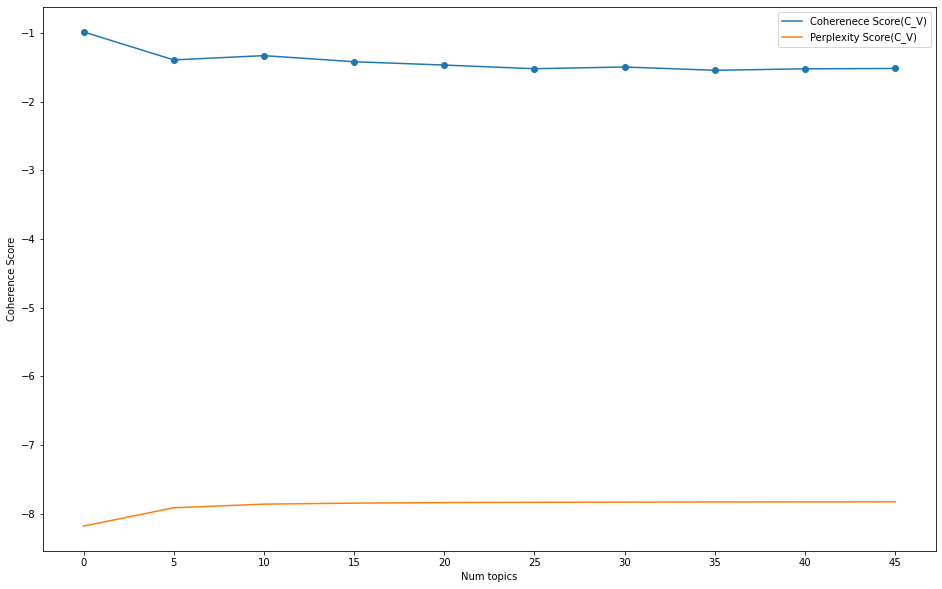

In [41]:
coherence_list = coherences
perplexity_list = perplexities
label = "Coherenece Score(C_V)"
label2 = 'Perplexity Score(C_V)'
x = range(0, 50, 5)
plt.figure(figsize=(16, 10))
plt.xticks(x)
plt.plot(x, coherence_list, label=label)
plt.plot(x, perplexity_list, label=label2)
plt.scatter(x, coherence_list)
# plt.title(f"Coherence Scores for LDA with {file_name}")
plt.xlabel("Num topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

In [42]:
coherences=[]
perplexities=[]
passes=[]
warnings.filterwarnings('ignore')

for i in tqdm(range(10)):
    
    ntopics, nwords = 200, 100
    if i==0:
        p=1
    else:
        p=i*5
    tic = time.time()
    lda4 = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=p, iterations=400, passes=10,random_state=42)
    print('epoch',p,time.time() - tic)
    # tfidf, corpus 무슨 차이?
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexities.append(lda4.log_perplexity(corpus))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1 15.966634511947632
Cpherence -0.6597587499000053
Perplexity:  -8.158601718347352 




 10%|█         | 1/10 [00:20<03:06, 20.76s/it]

epoch 5 57.4610550403595
Cpherence -1.0595334957742473
Perplexity:  -7.786067037431812 




 20%|██        | 2/10 [01:26<06:17, 47.15s/it]

epoch 10 62.06409025192261
Cpherence -1.3290328349275353
Perplexity:  -7.860103556961661 




 30%|███       | 3/10 [02:37<06:46, 58.10s/it]

epoch 15 68.58191108703613
Cpherence -1.7636239174115402
Perplexity:  -8.008288855948118 




 40%|████      | 4/10 [03:56<06:37, 66.25s/it]

epoch 20 88.7060067653656
Cpherence -2.400643803476348
Perplexity:  -8.071572883855715 




 50%|█████     | 5/10 [05:38<06:36, 79.20s/it]

epoch 25 145.4634997844696
Cpherence -2.1464593462814285
Perplexity:  -8.143516944316225 




 60%|██████    | 6/10 [08:24<07:14, 108.60s/it]

epoch 30 195.81543707847595
Cpherence -2.113839066783444
Perplexity:  -8.22969598848368 




 70%|███████   | 7/10 [12:07<07:18, 146.18s/it]

epoch 35 263.3234386444092
Cpherence -2.449638272450095
Perplexity:  -8.314263367410076 




 80%|████████  | 8/10 [17:06<06:29, 194.63s/it]

epoch 40 448.15173077583313
Cpherence -2.3585471090321617
Perplexity:  -8.410512983535654 




 90%|█████████ | 9/10 [25:12<04:45, 285.96s/it]

epoch 45 234.5758674144745
Cpherence -2.2519650835865477
Perplexity:  -8.493181291470284 




100%|██████████| 10/10 [29:39<00:00, 177.98s/it]


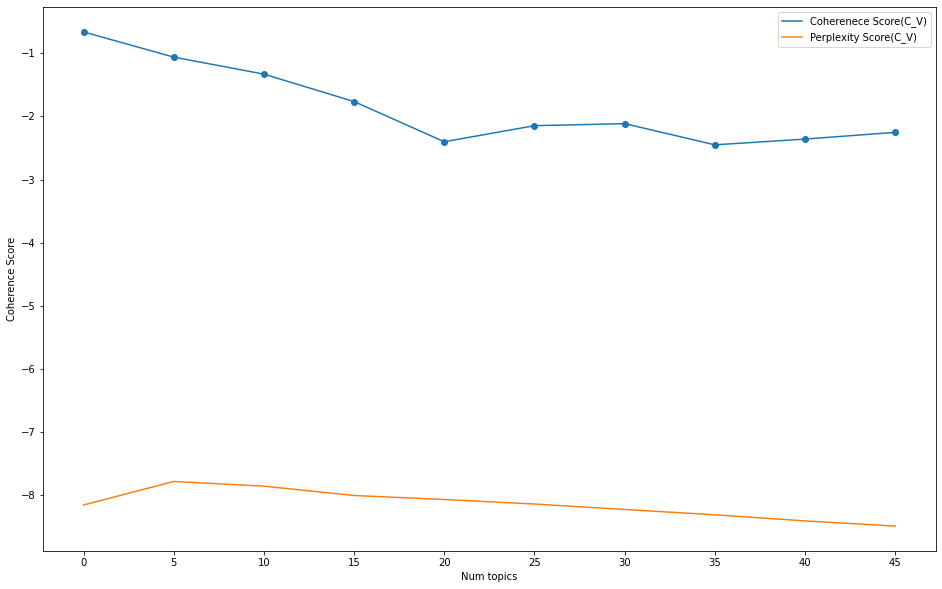

In [43]:
coherence_list = coherences
perplexity_list = perplexities
label = "Coherenece Score(C_V)"
label2 = 'Perplexity Score(C_V)'
x = range(0, 50, 5)
plt.figure(figsize=(16, 10))
plt.xticks(x)
plt.plot(x, coherence_list, label=label)
plt.plot(x, perplexity_list, label=label2)
plt.scatter(x, coherence_list)
# plt.title(f"Coherence Scores for LDA with {file_name}")
plt.xlabel("Num topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

In [45]:
NUM_TOPICS = 100
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=30, random_state=42)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(82, '0.030*"생각" + 0.025*"시장" + 0.020*"회사" + 0.015*"성장"')
(86, '0.114*"제장" + 0.026*"腰痛" + 0.021*"해석" + 0.021*"음양"')
(4, '0.077*"의료" + 0.033*"한의사" + 0.030*"기관" + 0.023*"사용"')
(33, '0.043*"삽입" + 0.034*"배농" + 0.032*"골프" + 0.031*"절개"')
(71, '0.023*"복장" + 0.017*"옥규" + 0.011*"검기" + 0.009*"입지"')
(15, '0.025*"동의보감" + 0.025*"나무" + 0.024*"효능" + 0.022*"갯벌"')
(0, '0.044*"손목" + 0.027*"치료" + 0.027*"손가락" + 0.021*"검사"')
(52, '0.063*"뇌졸중" + 0.051*"노인" + 0.027*"노화" + 0.024*"파킨슨병"')
(55, '0.044*"시간" + 0.041*"근로자" + 0.040*"근로" + 0.039*"근무"')
(98, '0.041*"치료" + 0.024*"남편" + 0.024*"가슴" + 0.018*"감초"')
(17, '0.046*"효과" + 0.043*"사용" + 0.039*"약물" + 0.029*"작용"')
(6, '0.048*"의학" + 0.028*"임상" + 0.016*"교수" + 0.014*"치료"')
(37, '0.103*"통증" + 0.055*"무릎" + 0.040*"관절" + 0.018*"대퇴"')
(76, '0.053*"저작" + 0.032*"출판사" + 0.029*"보호" + 0.028*"허락"')
(69, '0.078*"변증" + 0.066*"진찰" + 0.037*"보수" + 0.037*"직장"')
(18, '0.031*"소화" + 0.031*"복용" + 0.025*"처방" + 0.019*"경과"')
(3, '0.040*"환자" + 0.024*"당뇨병" + 0.023*"혈당" + 0.019*"치료"')
(28, '0.

In [46]:
ldamodel.get_topic_terms(2)

[(11417, 0.030509675),
 (446, 0.019578004),
 (8735, 0.019553754),
 (1360, 0.019532885),
 (445, 0.01719057),
 (15217, 0.014917405),
 (1622, 0.014624241),
 (17619, 0.01280114),
 (14492, 0.0118988035),
 (1850, 0.011553813)]

In [47]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(1, 0.048920233), (6, 0.36863744), (14, 0.015795063), (18, 0.011234787), (19, 0.015870454), (20, 0.32382813), (38, 0.010879428), (76, 0.01959543), (81, 0.029200053), (90, 0.048816923), (96, 0.087536946)]
1 번째 문서의 topic 비율은 [(1, 0.017140396), (4, 0.018373815), (5, 0.38704616), (6, 0.18114948), (20, 0.07560163), (23, 0.166637), (38, 0.04101481), (42, 0.039272387), (43, 0.013233239), (70, 0.024669241), (96, 0.025919544)]
2 번째 문서의 topic 비율은 [(6, 0.19153304), (22, 0.047350183), (23, 0.014461523), (37, 0.12820977), (57, 0.27288723), (85, 0.26580024), (89, 0.019036364), (92, 0.019639678), (96, 0.020581437)]
3 번째 문서의 topic 비율은 [(2, 0.16826), (70, 0.66838735)]
4 번째 문서의 topic 비율은 [(6, 0.07731383), (10, 0.0709123), (13, 0.015380253), (20, 0.03227298), (22, 0.13390988), (51, 0.011033807), (70, 0.016051866), (81, 0.15347101), (89, 0.46407717)]


In [48]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4),  [ dictionary[i[0]] for i in ldamodel.get_topic_terms(topic_num)][:10]   ]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [49]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 내용']
topictable

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 내용
0,0,6.0,0.3687,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
1,1,5.0,0.3870,"[감기, 항생제, 감염, 발열, 아이, 세균, 바이러스, 소아, 증상, 폐렴]"
2,2,57.0,0.2729,"[요통, 통증, 허리, 치료, 風濕, 환자, 목향, 두충, 제거, 발생]"
3,3,70.0,0.6684,"[질환, 진료, 치료, 증후군, 관련, 소아, 요법, 약물, 진단, 통증]"
4,4,89.0,0.4641,"[검사, 초음파, 전립선, 갑상선, 갑상샘, 진단, 배뇨, 스캔, 소견, 유방]"
...,...,...,...,...
3786,3786,29.0,0.3426,"[메디, 스트림, 업무, 본초학, 저희, 인턴, 개발, 기획, 콘텐츠, 도서]"
3787,3787,22.0,0.4424,"[영상, 초음파, 출처, 위치, 부위, 관찰, 확인, 아래, 사진, 부분]"
3788,3788,96.0,0.5192,"[연구, 논문, 결과, 근거, 임상, 평가, 검색, 분석, 효과, 관련]"
3789,3789,29.0,0.1694,"[메디, 스트림, 업무, 본초학, 저희, 인턴, 개발, 기획, 콘텐츠, 도서]"


In [79]:
df_des

,문서 번호,index,title,description
0,0,0,KCD 한방내과 진찰진단 가이드라인,의 번째 큐레이션 상시판매 권승원의 한방내과 진찰진단 가이드라인 의학은빠른속...
1,1,1,우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를 목표로 ...
2,2,2,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,_ 출판사 리뷰년전 소수 인원이 모여 시작한 통증 공부 모임이 작은 불씨가 ...
3,3,3,의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야 하는 응급의학 실전지침서
4,4,4,복부 초음파 정석,_ 저자서문 초음파 검사는 임상 영역에서 청진기로 불릴 정도로 간편한...
...,...,...,...,...
3805,3805,3433,"[나의 인턴 일지] Ep.04 한의대생, 퇴사를 했다.",선생님들 안녕하세요! 꽤 오랜만에 글을 씁니다. 저 퇴사를 했습...
3806,3806,3434,초음파 케이스: shoulder impingement synd. (SASD burs...,# CASE 13 houlder iigeet yd. SASD uriti 37...
3807,3807,3435,비판적으로 논문 읽기: 통계적 보정에 대해,"얼마 전 COVID-19를 앓고 난 뒤 남아 있는 여러 증상들, 롱 코비드Log ..."
3808,3808,3436,[작가가 입사했다] Ep.09 작가가.. 혹사했다..,"여름 휴가 기간은 쏜살같이 지났고, 여전히 메디스트림은 바쁘다. 엎친데 덮..."


In [85]:
concat=df_des.merge(topictable,how='inner',on='문서 번호')

In [96]:
concat[concat['가장 비중이 높은 토픽'] == 4]

,문서 번호,index,title,description,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 내용
384,384,12,테스트 겸 글 남겨봅니다.,모바일에서도 사진이 올라가네요 와우 그런데 잡담 공간이 옶네요ㅠㅠ,4.0,0.1952,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
409,409,37,화폐상습진 진단받은 환자입니다,양방에서 화폐상습진 진단 받은 환자분입니다. 온셋 1년이상 더 되었구...,4.0,0.2451,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
509,509,137,직원이 잘 인사를 안합니다,인사잘하는 직원한테 뭐라고 이야기 하면 좋을까요?? 한달된 직원인데 경력자라 일...,4.0,0.3300,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
533,533,161,한양방 협진병원에 입원중인 환자분이 내원하셨는데요,한방과 있는 양방병원에 입원 중인 환자분이 오셔서 진료를 받으신 적 있는분 있으신...,4.0,0.4948,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
595,595,223,신용카드 수수료 얼마나 나오나요?,개원 준비중인 뉴비입니다. 보건소 신고하고 카드 단말기 알아보는 중인데 수수료가...,4.0,0.5801,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
642,642,270,부인이 접수실 데스크에 나와있겠다는데 어떻게 해야하나요?,아침부터 충격적인 선언을 받았네요... 와이프가 육아휴직 하다가 재작년에 아예 ...,4.0,0.2087,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
1018,1018,646,Rotator cuff 제대로 이해하기,Rottor cuff ter 회전근개 파열 논문들에서는 주로 RCT로 표현...,4.0,0.4247,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
1036,1036,664,대진관련 문의드립니다.,"현재 주3월수금 + 주2목,일 이렇게 대진을 하고 있는데둘다 비상근등록입니다, 여...",4.0,0.3708,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
1040,1040,668,어깨 체외충격파에 대해 간단하게 이해하기,ESWT의 치료원리? 충격입니다. 실제로 받아보면 꽤 아픕니다. 가...,4.0,0.4860,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"
1046,1046,674,[청구] TENS나 ICT를 침전기자극술로 청구해도 되나요?,Q. 한의원에서 TENS나 ICT하면 처방입력을 침전기자극술로 해야 하나요? 한...,4.0,0.4073,"[의료, 한의사, 기관, 사용, 행위, 가능, 의약품, 기기, 문제, 한약]"


In [51]:
topictable[topictable['가장 비중이 높은 토픽'] == 6]

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 내용
0,0,6.0,0.3687,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
7,7,6.0,0.3665,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
9,9,6.0,0.3270,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
10,10,6.0,0.5656,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
13,13,6.0,0.2222,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
14,14,6.0,0.3820,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
15,15,6.0,0.4377,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
18,18,6.0,0.5243,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
24,24,6.0,0.2411,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"
27,27,6.0,0.2525,"[의학, 임상, 교수, 치료, 내용, 추천, 한의사, 소개, 활용, 생각]"


In [44]:
# !pip install pyldavis==3.2.1

In [50]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
data

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27    -0.239313  0.018049       1        1  5.110993
6     -0.108458 -0.232820       2        1  4.754770
81    -0.191179  0.086310       3        1  4.047466
20    -0.214871 -0.129400       4        1  3.343668
96    -0.136523 -0.177704       5        1  3.172850
99    -0.215707  0.088901       6        1  3.131200
87    -0.176462  0.077190       7        1  2.427598
90    -0.127157 -0.086421       8        1  2.177626
37    -0.141596  0.212095       9        1  2.169765
22    -0.109695  0.029939      10        1  2.167398
68    -0.193283 -0.007585      11        1  2.150266
51    -0.124560  0.066241      12        1  2.131358
94    -0.185283  0.062945      13        1  1.995971
76    -0.075756 -0.042833      14        1  1.979266
47    -0.177035  0.069232      15        1  1.976047
1     -0.064113 -0.243434      16        1  1.907006
61    -0.176313  0.146008      17        1  1.876409
8     -0.054782 -0.028462      18        1  1.801718
3     -0.169042  0.045806      19        1  1.749296
17    -0.112067  0.006650      20        1  1.716587
19    -0.068273 -0.015020      21        1  1.480783
18    -0.096526  0.086024      22        1  1.435385
97    -0.125174  0.067043      23        1  1.397419
85    -0.080013  0.129335      24        1  1.370335
79    -0.147962  0.094857      25        1  1.334913
59    -0.064967  0.158291      26        1  1.293068
35    -0.051912  0.102010      27        1  1.280967
25    -0.044082  0.037824      28        1  1.258590
88    -0.098564 -0.148718      29        1  1.229908
70    -0.056255  0.007813      30        1  1.168542
14    -0.070034 -0.116854      31        1  1.132906
4     -0.018959 -0.162197      32        1  1.088800
82    -0.051719 -0.240441      33        1  1.069899
53    -0.030003 -0.178563      34        1  0.989915
0     -0.132996  0.141278      35        1  0.949598
9     -0.073747 -0.024141      36        1  0.941710
28    -0.061309 -0.130953      37        1  0.926076
42    -0.045108  0.104943      38        1  0.905398
49    -0.109023  0.102705      39        1  0.902931
67     0.019011  0.064502      40        1  0.899560
46    -0.029533  0.093485      41        1  0.896920
38    -0.069173 -0.188903      42        1  0.882882
80    -0.063886 -0.021364      43        1  0.835254
78    -0.105251  0.039972      44        1  0.810137
5     -0.061513 -0.011776      45        1  0.774127
40    -0.014944 -0.037924      46        1  0.754651
95    -0.029328 -0.099046      47        1  0.714110
24    -0.021090 -0.030256      48        1  0.710558
57    -0.046148  0.144494      49        1  0.700849
54     0.047528  0.013836      50        1  0.688592
60    -0.092453  0.079064      51        1  0.673830
41    -0.013981 -0.077062      52        1  0.670787
64     0.033008  0.043753      53        1  0.659591
26     0.030143 -0.078774      54        1  0.627449
83    -0.032157 -0.070593      55        1  0.620090
52    -0.086772 -0.015008      56        1  0.593953
89     0.036367  0.095161      57        1  0.592513
77     0.008010 -0.092739      58        1  0.579705
29     0.048053 -0.177759      59        1  0.540781
32     0.061606 -0.049857      60        1  0.515956
92     0.020174  0.108379      61        1  0.496118
62     0.025370 -0.034083      62        1  0.493359
43    -0.001769 -0.069045      63        1  0.481288
21     0.021314 -0.039075      64        1  0.472598
30     0.033411  0.090801      65        1  0.467030
45     0.051867 -0.162111      66        1  0.462060
23    -0.024744  0.066111      67        1  0.458382
39     0.011046  0.043489      68        1  0.454948
65     0.092027  0.067084      69        1  0.408896
13     0.097695  0.054249      70        1  0.395356
84     0.016150 -0.023418      71        1  0.388940
12     0.091362 -0.025797      72        1  0.376713
73     0.075157 -0.118783      73        1  0.3